In [216]:
import requests
from lxml import etree
from typing import List
import arrow
import datetime
import pandas as pd
import numpy as np
import pathlib

In [217]:
dir_path_str:str=r'D:\01Proj\OceanSpider\qinglan_2021_source'

In [218]:
dir_path=pathlib.Path(dir_path_str)
full_path_str:str=str(dir_path/'qinglan_2021_all.csv')

In [219]:
full_path_str

'D:\\01Proj\\OceanSpider\\qinglan_2021_source\\qinglan_2021_all.csv'

In [220]:
def init_all_year_ser(year: int, freq: str = '1H'):
    """
        生成指定年份的整点series
    :param year:
    :return:
    """
    start_utc_ar = arrow.get(year, 1, 1)
    end_utc_ar = start_utc_ar.shift(days=365).shift(seconds=-1)

    dt_index = pd.date_range(start_utc_ar.datetime, end_utc_ar.datetime, freq=freq, name='ts')
    return dt_index

In [221]:
# step2: 数据标准化
# TODO:[*] 此处在提取整点时刻的数据时出错！,注意
read_df = pd.read_csv(full_path_str, parse_dates=['ts'])
# step2-1: 将爬取的原始数数据按照时间间隔为1min提取为分钟数据，并按照向上填充的方式进行填充
def str2int64(val: str):
    return np.int64(val)
def dt64ToTs(val64):
    """
        datetime64[ns] -> timestamp
    :param val:
    :return:
    """
    # 注意此处需要转换为 int 时间戳
    dt: datetime.datetime = pd.Timestamp(val64).to_pydatetime()
    return arrow.get(dt).int_timestamp

In [222]:
# 将时间戳 str -> int
read_df['ts'] = read_df.apply(lambda x: str2int64(x['ts']), axis=1)
read_df.set_index('ts')
# 生成 分钟级的索引列表
dt_split_minute_indexs = init_all_year_ser(2021, '60s')

In [223]:
dt_split_minute_indexs[:5]

DatetimeIndex(['2021-01-01 00:00:00+00:00', '2021-01-01 00:01:00+00:00',
               '2021-01-01 00:02:00+00:00', '2021-01-01 00:03:00+00:00',
               '2021-01-01 00:04:00+00:00'],
              dtype='datetime64[ns, tzutc()]', name='ts', freq='60S')

In [224]:
# 注意其中的 dt 为 numpy.datetime64 类型！
dt_split_minute_stamp_df = pd.DataFrame(
    {'index': np.arange(0, len(dt_split_minute_indexs)), 'dt': dt_split_minute_indexs})
# 将匹配的全部分钟df加入时间戳
dt_split_minute_stamp_df['ts'] = dt_split_minute_stamp_df.apply(lambda x: dt64ToTs(x['dt']), axis=1)
# 设置 ts 为 index
dt_split_minute_stamp_df.set_index('ts')
# 将该年份所有分钟数据按照就近原则进行填充
reslt_all_df = pd.merge(dt_split_minute_stamp_df, read_df, on='ts', how='outer')
# reslt_all_df = reslt_all_df.fillna(method='ffill', axis=0)[['dt_x', 'ts', 'rad']]

In [256]:
dt_split_minute_stamp_df

,index,dt,ts
0,0,2021-01-01 00:00:00+00:00,1609459200
1,1,2021-01-01 00:01:00+00:00,1609459260
2,2,2021-01-01 00:02:00+00:00,1609459320
3,3,2021-01-01 00:03:00+00:00,1609459380
4,4,2021-01-01 00:04:00+00:00,1609459440
...,...,...,...
525595,525595,2021-12-31 23:55:00+00:00,1640994900
525596,525596,2021-12-31 23:56:00+00:00,1640994960
525597,525597,2021-12-31 23:57:00+00:00,1640995020
525598,525598,2021-12-31 23:58:00+00:00,1640995080


In [225]:
# -----
# step2-2: 将分钟数据提取整点时刻并存储至新的文件
dt_split_hours_indexs = init_all_year_ser(2021)
# 整点时间标记df
dt_split_hours_stamp_df = pd.DataFrame(
    {'index': np.arange(0, len(dt_split_hours_indexs)), 'dt': dt_split_hours_indexs})
dt_split_hours_stamp_df['ts'] = dt_split_hours_stamp_df.apply(lambda x: dt64ToTs(x['dt']), axis=1)
dt_split_hours_stamp_df.set_index('ts')
# 将 read_df 与 dt_split_hours_stamp_df 合并
# TODO: [*] 22-04-27 注意 使用 how='outer' 时会出现 : ValueError: Timezones don't match. 'tzutc()' != 'UTC'
# 使用 int timestamp 后 ,merge 出现 : {ValueError}You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat
# 注意 read_df 中的 ts 是 str | dt_split_hours_stamp_df 中的 ts 是 int64
# 切记此处由于是需要将全部分钟数据提取为 整点数据，所以此处切记不要写成reslt_df，这有一个隐藏bug，注意！
reslt_df = pd.merge(dt_split_hours_stamp_df, reslt_all_df, on='ts', how='left')
# 注意此处不需要再执行填充操作了，因为上面的全分钟df已经包含了可能的全部时间
# reslt_df = reslt_df.fillna(method='ffill', axis=0)[['dt_x', 'ts', 'rad']]
# to_store('/opt/project', 'qinglan_2021_fill.csv', reslt_df)
# to_store('/opt/project', 'qinglan_2021_split_hours.csv', reslt_df)

In [226]:
import matplotlib.pyplot as plt
import datetime

---

### step3:获取该年份所有月份，并获取每个月份的起止时间，获取线性插值之后的 `dataframe`  
* 对`dataframe`进行差值使用了`.interpolate`方法，api参考:  
[Pandas DataFrame interpolate() 方法](https://cankaoshouce.com/pandas-ref-dataframe/pandas-df-interpolate.html)  
[pandas：超级方便的插值函数interpolate](https://zhuanlan.zhihu.com/p/357459373)  
[官方api](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html)  
* 使用拉格朗日差值填充 nan (未用到)  
[使用拉格朗日插值填充NaN值](https://zhuanlan.zhihu.com/p/477808536)

In [227]:
def inter_rad_month(start,end,df:pd.DataFrame)->pd.DataFrame:
    '''
        根据 起止时间 对 df 进行线性插值
    '''
    # step1: datetime.datetime -> timestamp
    start_ts=pd.Timestamp(start).timestamp()
    end_ts=pd.Timestamp(end).timestamp()
    con1=df['ts']>start_ts
    con2=df['ts']<end_ts
    reslt_filter_df=reslt_all_df[con1&con2]
    reslt_source_df=reslt_filter_df.copy()
    rad_inter_list=reslt_filter_df['rad'].interpolate(method='linear',limit=60,limit_direction ='backward')
    reslt_filter_df['rad']=rad_inter_list
    return [reslt_source_df,reslt_filter_df]

----

### S-1 查看指定时间段

In [228]:
start=datetime.datetime(2021,1,1)
end=datetime.datetime(2021,2,1)

In [229]:
dfs=inter_rad_month(start,end,reslt_all_df)

C:\Users\evase\Anaconda3\envs\new_oil_gdal\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [230]:
start_filter=datetime.datetime(2021,1,14)
end_filter=datetime.datetime(2021,1,15)
start_filter_pd_ts=pd.Timestamp(start_filter)
start_filter_ts=start_filter_pd_ts.timestamp()
end_pd_ts=pd.Timestamp(end_filter)
end_filter_ts=end_pd_ts.timestamp()

In [231]:
dfs_source=dfs[0]

In [232]:
con1=dfs_source['ts']>start_filter_ts
con2=dfs_source['ts']<end_filter_ts

In [242]:
dfs_source_res=dfs_source[con1&con2]
# 注意此处需要重置索引否则会有问题
dfs_source_res.reset_index(inplace=True, drop=True)

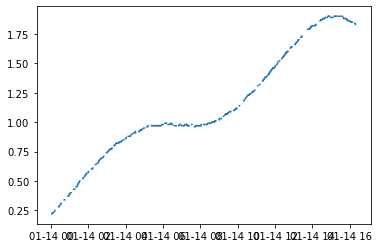

In [234]:
plt.plot(dfs_source_res['dt_x'],dfs_source_res['rad'])
plt.show()


In [235]:
dfs_inter=dfs[1]

In [236]:
con1=dfs_inter['ts']>start_filter_ts
con2=dfs_inter['ts']<end_filter_ts
dfs_inter_res=dfs_inter[con1&con2]

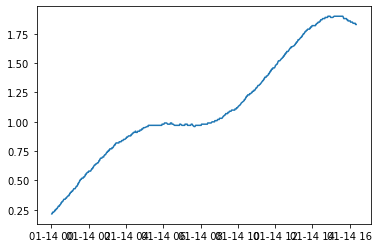

In [237]:
plt.plot(dfs_inter_res['dt_x'],dfs_inter_res['rad'])
plt.show()

### S-2 将 `df1`与 `df2`中的`rad`列进行互斥

In [33]:
dfs_diff_res=pd.concat([dfs_source_res,dfs_inter_res]).drop_duplicates(keep=False)

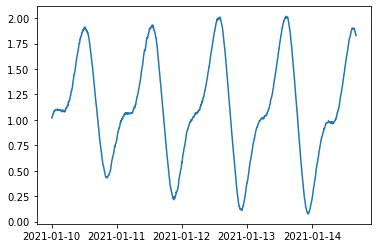

In [34]:
plt.plot(dfs_diff_res['dt_x'],dfs_diff_res['rad'])
plt.show()

---

In [85]:
def merge_mutual(df1,df2,col_name:str)->pd.DataFrame:    
    dfs_diff_series=[]
    for index in range(len(df1)):
        if df1.iloc[index][col_name]!=df2.iloc[index][col_name]:
            dfs_diff_series.append(np.nan)
        else:
            dfs_diff_series.append(df1.iloc[index][col_name])
    reutrn dfs_diff_series

In [238]:
def conduct_nan(df: pd.DataFrame, count_max: int, nan_val: np.float64, col_name: str):
    '''
        处理 df 中的nan
        对于连续 len 的 nan，找到最后的nan index，并将 [index-len,index] 均设置为 nan_val，直到连续的 nan < len 为止
    '''
    df_copy = df.copy()
    if len(df_copy) < count_max:
        return
    # 逐行遍历
    for index in range(len(df_copy)):
#         print(f'正在处理{index}行数据')
        temp = df_copy.iloc[index][col_name]
        # 判断是否为 nan 且 是否为超出 df 的行范围
        if pd.isna(temp) and len(df_copy) > index + 1:
            count = 0
            count = count + 1
            next_index = 0
            last_index = 0
            while True:
                next_index = next_index + 1
                # 总的数据量 > 当前 index + 增量
                if len(df_copy) > index + next_index:
                    # TODO:[*] 若最后一个是 nan
                    # IndexError: single positional indexer is out-of-bounds
                    next_temp = df_copy.iloc[index + next_index][col_name]
                    if pd.isna(next_temp):
                        count = count + 1
                        # last_index = next_index
                        # if count > count_max:
                        #     #  注意此处应该是将所有的 在 [index,last_index] 均设置为 nan_val
                        #     df.iloc[index: next_index][col_name] = nan_val
                        # else:
                        #     pass
                    else:
                        break
                else:
                    break
            if count > count_max:
                #  注意此处应该是将所有的 在 [index,last_index] 均设置为 nan_val
                # TODO:[*] - 22-05-09 注意此处 range(a,b) b一定要大于a!
                for df_index in range(index, index + count):
                    if len(df_copy) >= df_index:
                        try:
                            # TODO:[-] 22-05-10 切记不要通过 iloc[index][column_name] 的方式进行赋值!
                            df_copy.loc[df_index, col_name] = nan_val
                        except IndexError as e:
                            msg = f'处理到{df_index}时出错,msg:{e}'
                            print(msg)

    return df_copy

In [243]:
df_new=conduct_nan(dfs_source_res,60,np.float64(99998),'rad')

In [244]:
df_new

,index,dt_x,ts,Unnamed: 0,dt_y,rad
0,18721.0,2021-01-14 00:01:00+00:00,1610582460,NaN,NaN,NaN
1,18722.0,2021-01-14 00:02:00+00:00,1610582520,12988.0,2021-01-14 00:02:00+00:00,0.22
2,18723.0,2021-01-14 00:03:00+00:00,1610582580,12989.0,2021-01-14 00:03:00+00:00,0.22
3,18724.0,2021-01-14 00:04:00+00:00,1610582640,12990.0,2021-01-14 00:04:00+00:00,0.23
4,18725.0,2021-01-14 00:05:00+00:00,1610582700,NaN,NaN,NaN
...,...,...,...,...,...,...
1434,20155.0,2021-01-14 23:55:00+00:00,1610668500,NaN,NaN,99998.00
1435,20156.0,2021-01-14 23:56:00+00:00,1610668560,NaN,NaN,99998.00
1436,20157.0,2021-01-14 23:57:00+00:00,1610668620,NaN,NaN,99998.00
1437,20158.0,2021-01-14 23:58:00+00:00,1610668680,NaN,NaN,99998.00


#### step s2-2:剔除掉默认值为`-9999`的行

In [252]:
dfs_filter=df_new[df_new['rad']!=np.float64(99998)]

In [253]:
dfs_filter

,index,dt_x,ts,Unnamed: 0,dt_y,rad
0,18721.0,2021-01-14 00:01:00+00:00,1610582460,NaN,NaN,NaN
1,18722.0,2021-01-14 00:02:00+00:00,1610582520,12988.0,2021-01-14 00:02:00+00:00,0.22
2,18723.0,2021-01-14 00:03:00+00:00,1610582580,12989.0,2021-01-14 00:03:00+00:00,0.22
3,18724.0,2021-01-14 00:04:00+00:00,1610582640,12990.0,2021-01-14 00:04:00+00:00,0.23
4,18725.0,2021-01-14 00:05:00+00:00,1610582700,NaN,NaN,NaN
...,...,...,...,...,...,...
976,19697.0,2021-01-14 16:17:00+00:00,1610641020,13624.0,2021-01-14 16:17:00+00:00,1.84
977,19698.0,2021-01-14 16:18:00+00:00,1610641080,13625.0,2021-01-14 16:18:00+00:00,1.84
978,19699.0,2021-01-14 16:19:00+00:00,1610641140,13626.0,2021-01-14 16:19:00+00:00,1.83
979,19700.0,2021-01-14 16:20:00+00:00,1610641200,NaN,NaN,NaN


In [257]:
rad_list=dfs_filter['rad'].interpolate(method='linear',limit=60,limit_direction ='backward')
dfs_filter['rad']=rad_list

C:\Users\evase\Anaconda3\envs\new_oil_gdal\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


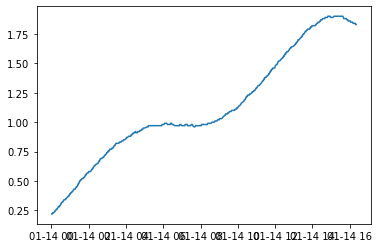

In [255]:
plt.plot(dfs_filter['dt_x'],rad_list.to_list())
plt.show()

----

对差值后的`df`按照全月时间再进行一次填充

In [259]:
reslt_all_df = pd.merge(dt_split_minute_stamp_df, dfs_filter, on='ts', how='outer')

In [262]:
reslt_all_df.head()

,index_x,dt,ts,index_y,dt_x,Unnamed: 0,dt_y,rad
0,0,2021-01-01 00:00:00+00:00,1609459200,NaN,NaT,NaN,NaN,NaN
1,1,2021-01-01 00:01:00+00:00,1609459260,NaN,NaT,NaN,NaN,NaN
2,2,2021-01-01 00:02:00+00:00,1609459320,NaN,NaT,NaN,NaN,NaN
3,3,2021-01-01 00:03:00+00:00,1609459380,NaN,NaT,NaN,NaN,NaN
4,4,2021-01-01 00:04:00+00:00,1609459440,NaN,NaT,NaN,NaN,NaN


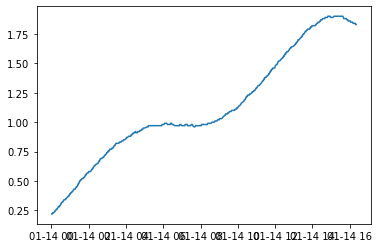

In [265]:
plt.plot(reslt_all_df['dt'],reslt_all_df['rad'])
plt.show()